In [2]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install boto3
!pip install sagemaker
!pip install pymongo

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymongo

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error, mean_absolute_error


import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve


import warnings
warnings.simplefilter('ignore')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [4]:
database_username = "admin01"
database_password = "LZRKfNnjX38rCOMs"
database_cluster_name = "bigdataforengineering.wef2a2d.mongodb.net"
connection_string = f"mongodb+srv://{database_username}:{database_password}@{database_cluster_name}/?retryWrites=true&w=majority"

database_name = 'processed_data'
client = pymongo.MongoClient(connection_string)

# Check if the connection was successful
if client.server_info():
    print("Connected to MongoDB successfully!")

db = client[database_name]

Connected to MongoDB successfully!


In [5]:
transformed_data = db['vndata_transformed']
cursor = transformed_data.find({})
data_list = list(cursor)
transformed_df = pd.DataFrame(data_list).drop('_id', axis=1)

transformed_df

,CARBON GROSS EMISSIONS,TROPICAL FOREST LOSS,YEAR,TEMP,TEMP_MIN,SUNRISE,SUNSET,HUMIDITY,PRESSURE,FEELS_LIKE,...,STATE BUDGET EXPENDITURE,INVESTMENT AT CURRENT PRICES,NUMBER OF FARM,PLANTED AREA OF CEREALS,PRODUCTION OF FISHERY,INDEX OF INDUSTRIAL PRODUCTION,RETAIL SALES OF GOODS,NUMBER OF SCHOOLS,NUMBER OF MEDICAL ESTABLISHMENTS,DESCRIPTION
0,24733.0,229.0,2015,301.12,301.12,1.704929e+09,1704970342,59.0,1009.0,302.45,...,17687.6,11228.7,697.0,319.55,348079.0,105.0,35835.0,547.00,191,6
1,110738.0,904.0,2016,303.12,303.12,1.704929e+09,1704970342,57.0,1009.0,305.35,...,18002.0,11920.3,1180.0,319.55,369843.0,105.7,38093.0,542.00,192,2
2,200469.0,930.0,2017,300.12,300.12,1.704929e+09,1704970342,74.0,1012.0,302.29,...,22522.4,13488.6,1063.0,319.55,401724.0,106.8,43129.0,536.00,677,5
3,126319.0,540.0,2018,298.12,298.12,1.704929e+09,1704970342,84.0,1012.0,298.87,...,24880.1,16146.9,1016.0,319.55,440373.5,108.9,47437.0,530.00,677,5
4,34024.0,174.0,2019,297.12,297.12,1.705015e+09,1705056774,87.0,1010.0,297.84,...,26701.5,17695.7,966.0,319.55,440373.5,109.9,51421.0,531.00,677,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,360933.0,752.0,2017,291.07,291.07,1.704930e+09,1704969292,97.0,1018.0,291.45,...,14413.5,10370.8,16.0,70.70,7497.0,106.9,12665.0,192.00,358,5
2201,226560.0,450.0,2018,291.72,291.72,1.704930e+09,1704969292,94.0,1016.0,292.09,...,16025.7,11105.3,32.0,70.60,9017.0,104.3,13868.0,197.00,371,5
2202,12688.0,63.0,2019,291.19,291.19,1.704930e+09,1704969292,96.0,1018.0,291.56,...,18480.1,13513.1,34.0,71.60,10485.0,110.9,15979.0,179.00,393,5
2203,970.0,8.0,2020,291.55,291.55,1.704930e+09,1704969292,95.0,1016.0,291.93,...,20472.8,15655.2,17.0,72.30,11634.0,108.1,16728.0,177.00,409,5


In [6]:
bucket_name = "model-training-asm3"


train_file = 'train_set.csv'
validation_file = 'validation_set.csv'
test_file = 'test_set.csv'


def upload_s3_csv(filename, folder, dataframe):
    """
    Uploads a pandas DataFrame to S3 as a CSV file.

    :param dataframe: pandas DataFrame to be uploaded
    :param filename: Name of the file to be created on S3
    :param folder: S3 key prefix (folder) under which the file should be stored
    :param bucket_name: Name of the S3 bucket
    :return: The S3 path of the uploaded file
    """
    # Create a boto3 S3 client
    s3_client = boto3.client('s3')

    # Ensure the filename ends with '.csv'
    if not filename.endswith('.csv'):
        filename += '.csv'

    # Create a temporary local file to save the DataFrame
    local_file_path = '/tmp/' + filename
    dataframe.to_csv(local_file_path, index=False)

    # Define the S3 key (path in the bucket)
    s3_key = os.path.join(folder, filename)

    # Upload the file to S3
    s3_client.upload_file(local_file_path, bucket_name, s3_key)

    # Return the S3 path
    return f"s3://{bucket_name}/{s3_key}"

In [7]:
# split the data into train, validation and test set with train = 2015 to 2020, and test = 2021
train_set = transformed_df[transformed_df['YEAR'] < 2021]
test_set = transformed_df[transformed_df['YEAR'] == 2021]

train_set.to_csv(train_file, index=False)
test_set.to_csv(test_file, index=False)

#### Upload train and test set into S3 Bucket

In [8]:
train_uploaded = upload_s3_csv(train_file, 'train', train_set)
test_uploaded = upload_s3_csv(test_file, 'test', test_set)

train_uploaded

's3://model-training-asm3/train/train_set.csv'

#### StandardScaler for other algorithm model

In [48]:
# split the train and test set into X and y
X_train = train_set.drop(['TROPICAL FOREST LOSS'], axis=1)
y_train = train_set['TROPICAL FOREST LOSS']
X_test = test_set.drop(['TROPICAL FOREST LOSS'], axis=1)
y_test = test_set['TROPICAL FOREST LOSS']


# Create a preprocessing pipeline
pipeline = Pipeline([('scaler', StandardScaler())])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)
# scale the target using standard scaler
y_train = pipeline.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test = pipeline.transform(y_test.values.reshape(-1, 1)).ravel()

### Model Comparision

In [49]:
def train_and_plot_metrics(models, X_train, y_train, X_test, y_test):

    for model_name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate metrics
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)

        # Print metrics
        print(f'{model_name} Metrics:')
        print(f'MAE (Training): {mae_train:.2f}  |  MAE (Test): {mae_test:.2f}')
        print(f'RMSE (Training): {rmse_train:.2f}  |  RMSE (Test): {rmse_test:.2f}')
        print(f'R-squared (Training): {r2_train:.2f}  |  R-squared (Test): {r2_test:.2f}')
        print('-' * 50)

# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor()
}

# Call the function with the specified models
train_and_plot_metrics(models, X_train, y_train, X_test, y_test)

Linear Regression Metrics:
MAE (Training): 0.12  |  MAE (Test): 0.15
RMSE (Training): 0.17  |  RMSE (Test): 0.22
R-squared (Training): 0.97  |  R-squared (Test): 0.94
--------------------------------------------------
Polynomial Regression Metrics:
MAE (Training): 0.02  |  MAE (Test): 0.38
RMSE (Training): 0.03  |  RMSE (Test): 0.56
R-squared (Training): 1.00  |  R-squared (Test): 0.58
--------------------------------------------------
Ridge Regression Metrics:
MAE (Training): 0.12  |  MAE (Test): 0.15
RMSE (Training): 0.17  |  RMSE (Test): 0.22
R-squared (Training): 0.97  |  R-squared (Test): 0.94
--------------------------------------------------
Lasso Regression Metrics:
MAE (Training): 0.82  |  MAE (Test): 0.72
RMSE (Training): 1.00  |  RMSE (Test): 0.88
R-squared (Training): 0.00  |  R-squared (Test): -0.04
--------------------------------------------------
Decision Tree Regressor Metrics:
MAE (Training): 0.00  |  MAE (Test): 0.12
RMSE (Training): 0.00  |  RMSE (Test): 0.21
R-squa

### Test the best model again in AWS Sagemaker

#### Creating a training model

In [50]:
%%writefile script.py

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sklearn
import joblib
import os
import numpy as np
import pandas as pd
import argparse

# Model function
def model_fn(model_dir):
    reg = joblib.load(os.path.join(model_dir, "model.joblib"))
    return reg

if __name__ == "__main__":

    print("[INFO] Extracting arguments")
    parser = argparse.ArgumentParser()

    # Hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--ccp_alpha", type=float, default=0.0)
    parser.add_argument("--max-depth", type=int, default=None)
    parser.add_argument("--criterion", type=str, default="squared_error")
    parser.add_argument("--splitter", type=str, default="best")
    parser.add_argument("--min_samples_leaf", type=int, default=1)
    parser.add_argument("--min_samples_split", type=int, default=2)
    parser.add_argument("--max_leaf_nodes", type=int, default=None)
    
    parser.add_argument("--random_state", type=int, default=0)


    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="train_set.csv")
    parser.add_argument("--test-file", type=str, default="test_set.csv")

    args, _ = parser.parse_known_args()
    
    print("SKLearn Version: ", sklearn.__version__)
    print("Joblib Version: ", joblib.__version__)

    print("[INFO] Reading data")
    print()
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))
    
    features = [col for col in train_df.columns if col != "TROPICAL FOREST LOSS"]
    label = "TROPICAL FOREST LOSS"
    
    print("Building training and testing datasets")
    print()
    X_train = train_df[features]
    X_test = test_df[features]
    y_train = train_df[label]
    y_test = test_df[label]
    
    pipeline = Pipeline([('scaler', StandardScaler())])
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)
    # scale the target using standard scaler
    y_train = pipeline.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test = pipeline.transform(y_test.values.reshape(-1, 1)).ravel()

    print('Column order: ')
    print(features)
    print()
    
    print("Label column is: ", label)
    print()
    
    print("Data Shape: ")
    print()
    print("---- SHAPE OF TRAINING DATA ----")
    print(X_train.shape)
    print(y_train.shape)
    print()
    print("---- SHAPE OF TESTING DATA ----")
    print(X_test.shape)
    print(y_test.shape)
    print()
    
    print("Training Decision Tree Regressor Model.....")
    print()
    model = DecisionTreeRegressor(random_state=args.random_state, max_depth=args.max_depth)
    model.fit(X_train, y_train)
    print()
    
    model_path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, model_path)
    print("Model persisted at " + model_path)
    print()

    y_pred_test = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    print()
    print("---- METRICS RESULTS FOR TESTING DATA ----")
    print()
    print("Total Rows are: ", X_test.shape[0])
    print('[TESTING] Model Mean Squared Error (MSE) is: ', test_mse)
    print('[TESTING] Model Root Mean Squared Error (RMSE) is: ', test_rmse)
    print('[TESTING] Model Mean Absolute Error (MAE) is: ', test_mae)
    print('[TESTING] Model R-squared (R2) is: ', test_r2)

Overwriting script.py


In [51]:
! python script.py --random_state 42 \
                   --model-dir ./ \
                   --train ./ \
                   --test ./ \

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[INFO] Extracting arguments
SKLearn Version:  1.3.2
Joblib Version:  1.3.2
[INFO] Reading data

Building training and testing datasets

Column order: 
['CARBON GROSS EMISSIONS', 'YEAR', 'TEMP', 'TEMP_MIN', 'SUNRISE', 'SUNSET', 'HUMIDITY', 'PRESSURE', 'FEELS_LIKE', 'TEMP_MAX', 'WIND', 'AREA OF LAND', 'POPULATION', 'POPULATION DENSITY', 'GROSS REGIONAL DOMESTIC PRODUCT', 'STATE BUDGET REVENUE', 'STATE BUDGET EXPENDITURE', 'INVESTMENT AT CURRENT PRICES', 'NUMBER OF FARM', 'PLANTED AREA OF CEREALS', 'PRODUCTION OF FISHERY', 'INDEX OF INDUSTRIAL PRODUCTION', 'RETAIL SALES OF GOODS', 'NUMBER OF SCHOOLS', 'NUMBER OF MEDICAL ESTABLISHMENTS', 'DESCRIPTION']

Label column is:  TROPICAL FOREST LOSS

Data Shape: 

---- SHAPE

### Train script in-side Sagemaker container

In [52]:
from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role

import sklearn

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="script.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="DT-custom-sklearn",
    hyperparameters={
        "random_state": 42,
    },
    use_spot_instances = True,
    max_wait = 7200,
    max_run = 3600
)

In [53]:
sklearn_estimator.fit({'train': train_uploaded, 'test': test_uploaded}, wait=True)

INFO:sagemaker:Creating training-job with name: DT-custom-sklearn-2024-01-16-15-35-38-124


2024-01-16 15:35:38 Starting - Starting the training job...
2024-01-16 15:35:53 Starting - Preparing the instances for training......
2024-01-16 15:37:06 Downloading - Downloading input data...
2024-01-16 15:37:37 Downloading - Downloading the training image.....2024-01-16 15:38:17,726 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-01-16 15:38:17,730 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-01-16 15:38:17,777 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-01-16 15:38:17,978 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-01-16 15:38:17,991 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-01-16 15:38:18,004 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-01-16 15:38:18,013 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
 

### Hyperparameter Tunning for Desicion Tree Regression

### Get the best params

In [55]:
from sklearn.model_selection import GridSearchCV

params = {
    "max_depth": [9,10,11],
    "min_samples_split": [15,17,19],
    "min_samples_leaf": [1, 2, 3],
    "criterion": ['squared_error','friedman_mse'],
    "splitter": ["best", "random"],
}
tree2 = DecisionTreeRegressor(random_state=42)
grid = GridSearchCV(estimator=tree2, param_grid=params)
grid.fit(X_train, y_train)
print("best params:", grid.best_params_)

best params: {'criterion': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 15, 'splitter': 'best'}


### Prepare for pruning model

In [66]:
def find_max_leaf_node(Xtrain, ytrain):
    max_leaf_nodes = []
    # loop through the range of 2 to 100
    for i in range(2, 100):
        tree = DecisionTreeRegressor(max_leaf_nodes=i, random_state=0)
        tree.fit(Xtrain, ytrain)
        max_leaf_nodes.append(tree.tree_.node_count)
    return max_leaf_nodes
max_leaf_node = find_max_leaf_node(X_train, y_train)
print(max(max_leaf_node))

197


In [67]:
model = grid.best_estimator_
print(grid.best_params_)
model.fit(X_train, y_train)
# predict and print the rmse, r2 and mae
y_pred = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

{'criterion': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 15, 'splitter': 'best'}
RMSE: 0.2328685941706543
R2: 0.9274346476546479
MAE: 0.13760412084148893


In [68]:
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
print("CCP Alphas: ", ccp_alphas)
clfs = []
for ccp_alpha in ccp_alphas:
    tree3 = DecisionTreeRegressor(random_state=420, ccp_alpha=ccp_alpha)
    tree3.fit(X_train, y_train)
    clfs.append(tree3)


CCP Alphas:  [0.00000000e+00 4.84033742e-17 1.06782989e-11 1.53835730e-11
 1.69195821e-11 2.14307722e-11 1.17683654e-10 2.31733948e-10
 2.50643428e-10 4.03773211e-10 6.42922629e-10 6.95906395e-10
 8.54263983e-10 8.72580235e-10 8.82628218e-10 1.12159226e-09
 2.20740480e-09 2.88614429e-09 3.05412086e-09 3.95697747e-09
 4.22701241e-09 6.22185661e-09 7.34678153e-09 8.23156028e-09
 8.81033892e-09 1.41132589e-08 1.89376682e-08 1.93420717e-08
 2.11789988e-08 2.64084701e-08 3.23297457e-08 3.61908682e-08
 4.11470488e-08 6.79199194e-08 7.61720577e-08 8.04120613e-08
 8.15558859e-08 9.38352967e-08 1.14207754e-07 1.28139598e-07
 1.38871290e-07 1.40692533e-07 1.65788741e-07 1.89407615e-07
 2.50240692e-07 2.62241618e-07 2.66517323e-07 2.86894327e-07
 3.26015613e-07 3.60250984e-07 4.65930188e-07 5.25404541e-07
 5.28589190e-07 5.74179302e-07 5.74494509e-07 5.93473766e-07
 7.14744754e-07 7.73114841e-07 8.61741764e-07 9.59890541e-07
 1.02170566e-06 1.03447698e-06 1.09307564e-06 1.18226799e-06
 1.20737163

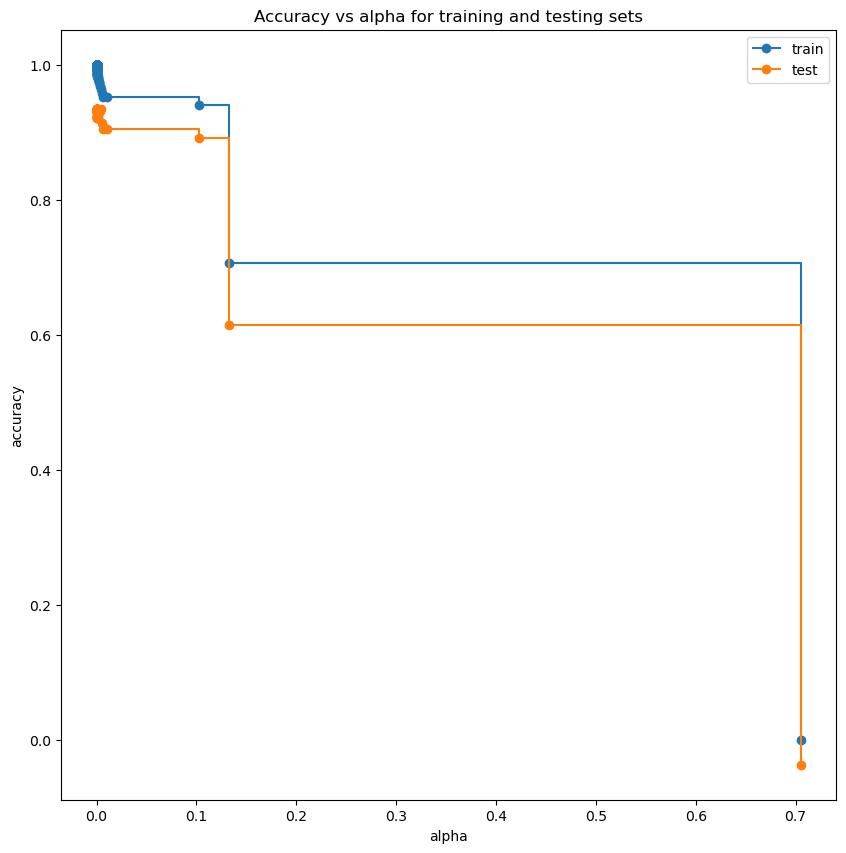

In [69]:
#  plot the result for each alphas and impurities
train_scores = [tree3.score(X_train, y_train) for tree3 in clfs]
test_scores = [tree3.score(X_test, y_test) for tree3 in clfs]
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

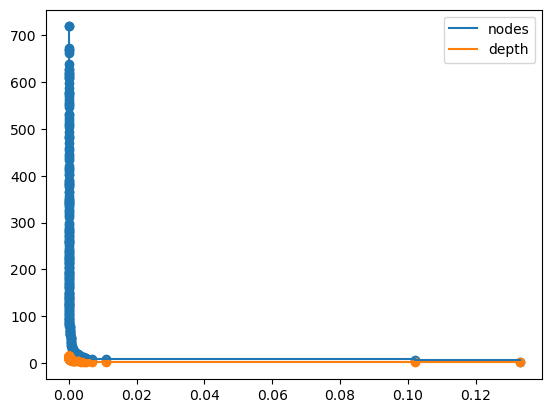

In [70]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()


### Finalize the model and train script in-side Sagemaker container again.

In [102]:
FRAMEWORK_VERSION = "0.23-1"

sklearn_finalize = SKLearn(
    entry_point="script.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="DT-custom-sklearn",
    hyperparameters={
        "ccp_alpha": 8.61255641e-03,
        "max-depth": 11,
        "criterion": "squared_error",
        "splitter": "best",
        "min_samples_leaf": 1,
        "min_samples_split": 15,
        "max_leaf_nodes": 197,
        "random_state": 42,
    },
    use_spot_instances=True,
    max_wait=7200,
    max_run=3600
)

In [103]:
sklearn_finalize.fit({'train': train_uploaded, 'test': test_uploaded}, wait=True)

INFO:sagemaker:Creating training-job with name: DT-custom-sklearn-2024-01-16-17-04-12-261


2024-01-16 17:04:12 Starting - Starting the training job...
2024-01-16 17:04:29 Starting - Preparing the instances for training......
2024-01-16 17:05:39 Downloading - Downloading input data...
2024-01-16 17:06:10 Downloading - Downloading the training image...
2024-01-16 17:06:40 Training - Training image download completed. Training in progress...2024-01-16 17:06:45,625 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-01-16 17:06:45,627 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-01-16 17:06:45,665 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-01-16 17:06:45,831 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-01-16 17:06:45,842 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-01-16 17:06:45,852 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-01-16

### Store Model Artifacts (model.tar.gz) into the S3 Bucket.

In [104]:
sm_boto3 = boto3.client("sagemaker")

sklearn_finalize.latest_training_job.wait(logs="None")
artifact = sm_boto3.describe_training_job(
    TrainingJobName=sklearn_finalize.latest_training_job.name
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact)


2024-01-16 17:07:06 Starting - Preparing the instances for training
2024-01-16 17:07:06 Downloading - Downloading the training image
2024-01-16 17:07:06 Training - Training image download completed. Training in progress.
2024-01-16 17:07:06 Uploading - Uploading generated training model
2024-01-16 17:07:06 Completed - Training job completed
Model artifact persisted at s3://sagemaker-us-east-1-295202471063/DT-custom-sklearn-2024-01-16-17-04-12-261/output/model.tar.gz


### Deploy Sagemaker Endpoint(API) for trained model, and test it.

In [114]:
from sagemaker.sklearn.model import SKLearnModel
from time import gmtime, strftime

model_name = "Custom-sklearn-model-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model = SKLearnModel(
    name=model_name,
    model_data=artifact,
    role=get_execution_role(),
    entry_point="script.py",
    framework_version=FRAMEWORK_VERSION,
)

In [115]:
endpoint_name = "Custom-sklearn-model-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("EndpointName={}".format(endpoint_name))

predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    endpoint_name=endpoint_name,
)

EndpointName=Custom-sklearn-model-2024-01-16-17-15-10


INFO:sagemaker:Creating model with name: Custom-sklearn-model-2024-01-16-17-15-06
INFO:sagemaker:Creating endpoint-config with name Custom-sklearn-model-2024-01-16-17-15-10
INFO:sagemaker:Creating endpoint with name Custom-sklearn-model-2024-01-16-17-15-10


-------!

In [116]:
LastTestPred = predictor.predict(X_test)
LastTestPred = pipeline.inverse_transform(LastTestPred.reshape(-1, 1)).ravel()

In [117]:
print(LastTestPred)

[1.74000000e+02 6.59400000e+03 3.23472500e+04 6.89850000e+04
 1.64960000e+04 5.23430000e+04 4.00000000e+01 4.39850000e+04
 5.45630000e+04 5.00000000e+00 3.30000000e+01 1.25560000e+04
 9.33500000e+03 9.00000000e+00 3.15980000e+04 1.91690000e+04
 1.64960000e+04 5.18333333e+02 1.02800000e+03 4.84030000e+04
 9.00000000e+00 9.64000000e+02 7.50000000e+01 2.48000000e+02
 4.10000000e+02 3.05645000e+04 2.61800000e+03 3.83630000e+04
 1.05180000e+04 7.41000000e+02 1.15230000e+04 2.28785000e+04
 1.21108500e+05 1.10000000e+01 1.21108500e+05 1.34800000e+03
 2.90100000e+03 3.19280000e+04 3.48375000e+04 5.84350000e+04
 1.14622000e+05 9.36250000e+04 8.73950000e+04 4.02665000e+04
 7.41000000e+02 2.45625000e+04 7.14450000e+04 6.33333333e+00
 6.33430000e+04 5.23430000e+04 1.77000000e+02 3.30000000e+01
 6.91790000e+04 3.05645000e+04 2.63333333e+01 2.76000000e+03
 4.89500000e+04 2.28785000e+04 8.50600000e+03 4.41770000e+04
 2.38100000e+04 3.05645000e+04 1.10000000e+01 1.74000000e+02
 6.59400000e+03 3.234725

In [118]:
y_test_final = pipeline.inverse_transform(y_test.reshape(-1, 1)).ravel()

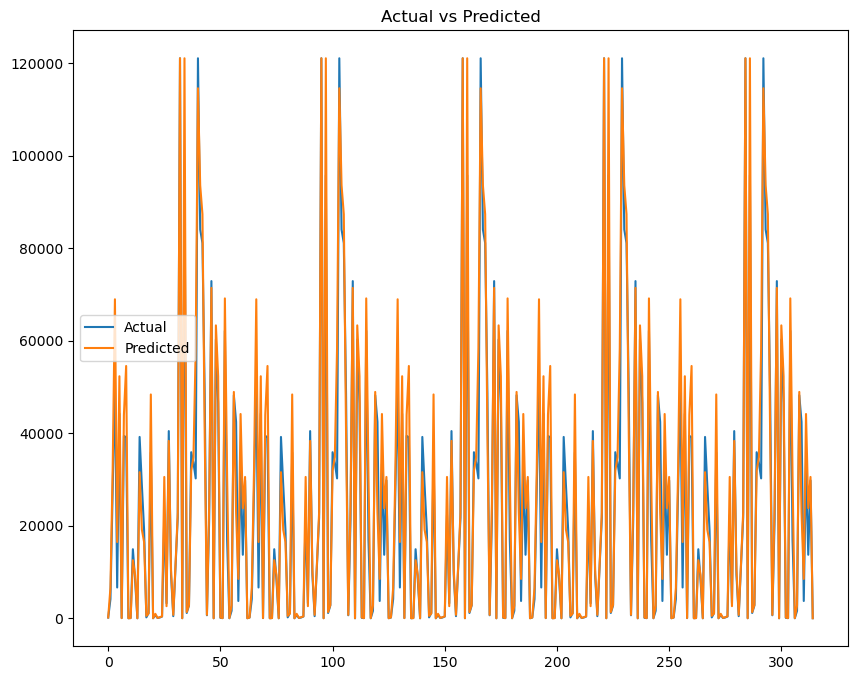

In [119]:
plt.figure(figsize=(10,8))
plt.plot(y_test_final, label="Actual")
plt.plot(LastTestPred, label="Predicted")
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

### Delete endpoint

In [120]:
sm_boto3.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '97ce376c-1723-4a9c-b878-56fda7d8ef2e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '97ce376c-1723-4a9c-b878-56fda7d8ef2e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 16 Jan 2024 17:19:14 GMT'},
  'RetryAttempts': 0}}